 # Two high-level analyses:
 - Predict performance (accuracy) using a regression
 - Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

 For github issues and brainstorming features and analyses, use github:
 - https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [1]:
import sys
import time
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse as str_parse
import seaborn as sns
import sklearn.feature_selection
from dateutil import parser as parser
from imblearn.ensemble import (BalancedBaggingClassifier,
                               BalancedRandomForestClassifier,
                               EasyEnsembleClassifier)
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model, svm, tree
from sklearn.base import BaseEstimator
from sklearn.ensemble import (BaggingClassifier, BaggingRegressor,
                              ExtraTreesClassifier, ExtraTreesRegressor,
                              RandomForestClassifier, VotingClassifier)
from sklearn.feature_selection import RFECV, SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             r2_score, recall_score)
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import multiprocessing as mp
import warnings

from new_proximity.intersection_proximity import compute_proximity
from region_stats import RegionStats


Using TensorFlow backend.


In [2]:
# users = pd.read_csv('ml-users.csv')
users = pd.read_csv('users_one_mission.csv')
users = users.set_index('user_id')
##%%
point_labels = pd.read_csv('sidewalk-seattle-label_point.csv')
point_labels.set_index('label_id', inplace=True)
##%%
# label_correctness = pd.read_csv('ml-label-correctness.csv')
label_correctness = pd.read_csv('ml-label-correctness-one-mission.csv')
##%%
label_correctness.set_index('label_id', inplace=True)
##%%
label_correctness = label_correctness.join(point_labels)
##%%
label_correctness = label_correctness[['user_id', 'label_type', 
    'correct', 'sv_image_x', 'sv_image_y', 'canvas_x', 'canvas_y', 
    'heading', 'pitch', 'zoom', 'lat', 'lng']]

##%%
users_for_analysis = users.index[users['labels_validated'] > 0]
label_correctness = label_correctness[label_correctness['user_id'].isin(users_for_analysis)]
users = users.loc[users_for_analysis]
##%%
label_correctness.update(label_correctness['correct'][~pd.isna(label_correctness['correct'])] == 't')
##%%
label_type_encoder = OrdinalEncoder()
##%%
label_correctness['label_type'] = label_type_encoder.fit_transform(label_correctness[['label_type']])


 # Intersection Proximity

In [3]:
def get_proximity_info(label):
    try:
        distance, middleness = compute_proximity(label.lat, label.lng, cache=True)
    except Exception:
        distance = -1
        middleness = -1
    
    return pd.Series({
        'proximity_distance': distance,
        'proximity_middleness': middleness
    })

label_correctness = label_correctness.join(label_correctness.apply(get_proximity_info, axis=1))


 # CV Analysis
 cv_predictions = pd.read_csv('summary_user.csv').rename(

In [ ]:
label_types = ['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem']


In [ ]:
label_correctness = label_correctness.join(cv_predictions)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = label_correctness[~pd.isna(label_correctness['correct']) & ~pd.isna(label_correctness['cv_confidence']) & (label_correctness['label_type'] == label_encoded)]
    ax.set_xlabel('CV Confidence')
    ax.set_ylabel('relative count')
    ax.set_title(label_types[i])
    ax.hist(selection[selection['correct'].astype(bool)]['cv_confidence'], alpha=0.5, label='correct', density=True)
    ax.hist(selection[~selection['correct'].astype(bool)]['cv_confidence'], alpha=0.5, label='incorrect', density=True)
    ax.legend()

fig.tight_layout()

In [ ]:
prob = np.zeros((4, 4))
for i in range(len(label_types)):
    for j in range(len(label_types)):
        i_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
        j_encoded = label_type_encoder.transform([[label_types[j]]])[0][0]

        selection = label_correctness[~pd.isna(label_correctness['correct']) 
            & (label_correctness['label_type'] == i_encoded)
            & (label_correctness['cv_label_type'] == j_encoded)]
        
        prob[i][j] = np.sum(selection['correct']) / len(selection)


prob

 # Population Density

In [4]:
rs = RegionStats('data_seattle.geojson')
label_correctness = label_correctness.join(
    label_correctness.apply(lambda x: pd.Series(rs.get_properties(x.lng, x.lat)), axis=1)
)

In [6]:
selection_all = label_correctness[['density', 'correct', 'label_type']]
selection_all = selection_all[~pd.isna(selection_all).any(axis=1)]

KeyError: "['density'] not in index"

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = selection_all[selection_all['label_type'] == label_encoded]
    ax.set_xlabel('Population density (people/sq. mile)')
    ax.set_ylabel('count')
    ax.set_title(label_types[i])
    nc, bins, _ = ax.hist(selection[selection['correct'] == True]['density'], density=False, bins=20, alpha=0.5, label='correct')
    ni, _, _ = ax.hist(selection[selection['correct'] == False]['density'], density=False, bins=bins, alpha=0.5, label='incorrect')
    ax.legend()

    ax2 = axes2[i//2][i%2]
    ax2.set_xlabel('Population density (people/sq. mile)')
    ax2.set_ylabel('probability correct')
    ax2.set_title(label_types[i])
    density_vals = (bins[:-1] + bins[1:])/2
    correct_prob = nc / (ni + nc)
    mask = ~np.isnan(correct_prob)
    density_vals = density_vals[mask]
    correct_prob = correct_prob[mask]
    ax2.scatter(density_vals, correct_prob)

    
    z = np.polyfit(density_vals, correct_prob, 1)
    p = np.poly1d(z)
    ax2.plot(density_vals, p(density_vals), 
    label=f"R={r2_score(correct_prob, p(density_vals)):.3f}")

    ax2.legend()


fig.tight_layout()
fig2.tight_layout()


 # Zone type

In [5]:
rs = RegionStats('Zoning_Detailed.geojson')
label_correctness = label_correctness.join(
    label_correctness.apply(lambda x: pd.Series(rs.get_properties(x.lng, x.lat)), axis=1)
)


In [ ]:
selection_all = label_correctness[['CATEGORY_DESC', 'correct', 'label_type']]
selection_all = selection_all[~pd.isna(selection_all).any(axis=1)]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 10))
categories = selection_all['CATEGORY_DESC'].unique()

for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = selection_all[selection_all['label_type'] == label_encoded]
    # ax.set_xlabel('Population density (people/sq. mile)')
    # ax.set_ylabel('count')
    ax.set_title(label_types[i])
    prob_correct = dict()
    for category in categories:
        if np.sum(selection['CATEGORY_DESC'] == category) > 100:
            prob_correct[category] = np.mean(selection['correct'][selection['CATEGORY_DESC'] == category])
        else:
            prob_correct[category] = 0
        # num_in[category] = np.sum(selection['CATEGORY_DESC'] == category)

    ax.bar(prob_correct.keys(), prob_correct.values())
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

 # Classification

In [10]:
def prob_hist(probabilities, n_bins=5):
    return [np.mean(probabilities), np.std(probabilities),
        np.percentile(probabilities, 25), np.percentile(probabilities, 50),
        np.percentile(probabilities, 75), np.mean(probabilities[(probabilities > 0.25) | (probabilities < 0.75)])]
def dearray(array):
    return np.array([list(l) for l in array])


 # Tyler's features

In [6]:
user_quality_features = pd.read_csv('all_users.csv')
user_quality_features.set_index('user_id', inplace=True)


In [11]:
def get_p_r(users, label_correctness):
    features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng',]
    proportion_labels = 0.1
    comparisons = pd.DataFrame()
    split_num = 0
    np.random.seed(0)

    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
        X_train, X_test = users.index[train_index], users.index[test_index]
        y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]

        mask = np.random.permutation(np.arange(len(X_train)))
        users_labels_train = X_train[mask[:int(proportion_labels * len(mask))]]
        users_labels_test = X_train[mask[int(proportion_labels * len(mask)):]]

        train_labels = label_correctness[label_correctness['user_id'].isin(X_train)]
        test_labels = label_correctness[label_correctness['user_id'].isin(X_test)]
        #%%
        test_labels = test_labels.drop(columns='correct')
        #%%
        train_labels = train_labels[~pd.isna(train_labels['correct'])]
        train_labels = train_labels[~(pd.isna(train_labels[features]).any(axis=1))]
        # scaler = StandardScaler()
        # train_labels[features] = scaler.fit_transform(train_labels[features])

        #%%
        rfe_labels = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
               scoring='precision')
        clf_labels = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)
        # clf_accuracy = BalancedBaggingClassifier(n_jobs=-1, random_state=0, n_estimators=100)
        rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
        clf_accuracy = BalancedBaggingClassifier(random_state=0, n_jobs=-1, n_estimators=20)
        # clf = BalancedRandomForestClassifier(random_state=0)  

        # TODO don't eliminate all nans

        #%%
        # clf_labels.fit(train_labels[features], train_labels['correct'].astype(int))
    #     print('Training label classifier...')
        rfe_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values, 
            train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))

        clf_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values[:, rfe_labels.support_], 
            train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))

        train_labels = train_labels.join(pd.Series(
            data=clf_labels.predict_proba(train_labels[train_labels['user_id'].isin(users_labels_test)][features].values[:, rfe_labels.support_])[:, 1], 
            index=train_labels[train_labels['user_id'].isin(users_labels_test)].index).rename('prob'), how='outer')

        prob_hist_predictions = pd.DataFrame(train_labels[train_labels['user_id'].isin(users_labels_test)]
            .groupby('user_id').apply(lambda x:\
            prob_hist(x['prob'].values)).rename('prob'))

        prob_hist_predictions = prob_hist_predictions.join(user_quality_features)

    #     print('Training accuracy classifier...')
        rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1), 
            (y_train.loc[prob_hist_predictions.index] > 65).astype(int))

        clf_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1)[:, rfe_accuracy.support_], 
            (y_train.loc[prob_hist_predictions.index] > 65).astype(int))
        #%%
        # Probabililty correct
        useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)].copy()  # TODO don't eliminate all nans
        # useful_test[features] = scaler.transform(useful_test[features])
        # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
        useful_test.loc[:, 'prob'] = clf_labels.predict_proba(useful_test[features].values[:, rfe_labels.support_])[:, 1]

        # a = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob']))
        # break
        #%%

        # Now predict accuracy

        def predict_accuracy(probs, features):
            # fig = plt.figure()
            # plt.xlim(0, 1)
            # plt.hist(probs)

            # selected_probs = probs[~np.isnan(probs)]
            # return np.mean(selected_probs)
            # return clf_accuracy.predict_proba([np.concatenate((prob_hist(probs), features))])[:, 1][0]
            return clf_accuracy.predict([np.concatenate((prob_hist(probs), features))[rfe_accuracy.support_]])[0]

    #     print('Making predictions...')
        mean_probs = useful_test.groupby('user_id').apply(lambda x: predict_accuracy(x['prob'].values, user_quality_features.loc[x.name])).rename('predicted')

        #%%
        comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
        comparison['prob_hist'] = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob'].values))
        comparison['probs'] = useful_test.groupby('user_id').apply(lambda x: x['prob'].values)
        comparisons = comparisons.append(comparison)

        #%%

        split_num += 1

        # sys.stderr.write(f'{split_num} / 5\n')

    comparisons['accuracy'] = (comparisons['accuracy'] > 65).astype(int)

    mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
    # print(precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(accuracy_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(confusion_matrix(comparisons['accuracy'][mask], comparisons['predicted'][mask]))

    return precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]), recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask])


In [57]:
users_filtered = users[users['labels_validated'] > 45]

In [58]:
np.median(users_filtered['missions_completed'])

26.0

In [8]:
len(users_filtered)

112

In [63]:
features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng', 'proximity_distance', 'proximity_middleness', 'CLASS_DESC', 'ZONEID']

proportion_labels = 0.4
comparisons = pd.DataFrame()
split_num = 0
np.random.seed(0)

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users_filtered.index):
    X_train, X_test = users_filtered.index[train_index], users_filtered.index[test_index]
    y_train, y_test = users_filtered['accuracy'][train_index] > 65, users_filtered['accuracy'][test_index] > 65
#     y_train, y_test = users_filtered['missions_completed'][train_index] > 6, users_filtered['missions_completed'][test_index] > 6

    mask = np.random.permutation(np.arange(len(X_train)))
    users_labels_train = X_train[mask[:int(proportion_labels * len(mask))]]
    users_labels_test = X_train[mask[int(proportion_labels * len(mask)):]]

    train_labels = label_correctness[label_correctness['user_id'].isin(X_train)].copy()
    test_labels = label_correctness[label_correctness['user_id'].isin(X_test)].copy()
    #%%
    test_labels = test_labels.drop(columns='correct')
    #%%
    train_labels = train_labels[~pd.isna(train_labels['correct'])]
    train_labels = train_labels[~(pd.isna(train_labels[features]).any(axis=1))]
    test_labels = test_labels[~(pd.isna(test_labels[features]).any(axis=1))]
    # scaler = StandardScaler()
    # train_labels[features] = scaler.fit_transform(train_labels[features])
    
    en = OrdinalEncoder()
    en.fit(pd.concat((train_labels[['CLASS_DESC']], test_labels[['CLASS_DESC']])))
    train_labels[['CLASS_DESC']] = en.transform(train_labels[['CLASS_DESC']])
    test_labels[['CLASS_DESC']] = en.transform(test_labels[['CLASS_DESC']])

    #%%
    rfe_labels = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
           scoring='precision')
    clf_labels = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=30)
    # clf_accuracy = BalancedBaggingClassifier(n_jobs=-1, random_state=0, n_estimators=100)
    rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
    clf_accuracy = BalancedBaggingClassifier(random_state=0, n_jobs=-1, n_estimators=30)
    # clf = BalancedRandomForestClassifier(random_state=0)  
    
    # TODO don't eliminate all nans

    #%%
    # clf_labels.fit(train_labels[features], train_labels['correct'].astype(int))
    print('Training label classifier...')
    rfe_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values, 
        train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))
    
    clf_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values[:, rfe_labels.support_], 
        train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))
    
    train_labels = train_labels.join(pd.Series(
        data=clf_labels.predict_proba(train_labels[train_labels['user_id'].isin(users_labels_test)][features].values[:, rfe_labels.support_])[:, 1], 
        index=train_labels[train_labels['user_id'].isin(users_labels_test)].index).rename('prob'), how='outer')
    
    prob_hist_predictions = pd.DataFrame(train_labels[train_labels['user_id'].isin(users_labels_test)]
        .groupby('user_id').apply(lambda x:\
        prob_hist(x['prob'].values)).rename('prob'))
    
    prob_hist_predictions = prob_hist_predictions.join(user_quality_features)
    
    print('Training accuracy classifier...')
    rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
        prob_hist_predictions.drop(columns='prob').values), axis=1), 
        y_train.loc[prob_hist_predictions.index].astype(int))
    
    clf_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
        prob_hist_predictions.drop(columns='prob').values), axis=1)[:, rfe_accuracy.support_], 
        y_train.loc[prob_hist_predictions.index].astype(int))
    #%%
    # Probabililty correct
    useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)].copy()  # TODO don't eliminate all nans
    # useful_test[features] = scaler.transform(useful_test[features])
    # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
    useful_test.loc[:, 'prob'] = clf_labels.predict_proba(useful_test[features].values[:, rfe_labels.support_])[:, 1]

    # a = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob']))
    # break
    #%%

    # Now predict accuracy

    def predict_accuracy(probs, features):
        # fig = plt.figure()
        # plt.xlim(0, 1)
        # plt.hist(probs)
        
        # selected_probs = probs[~np.isnan(probs)]
        # return np.mean(selected_probs)
        # return clf_accuracy.predict_proba([np.concatenate((prob_hist(probs), features))])[:, 1][0]
        return clf_accuracy.predict([np.concatenate((prob_hist(probs), features))[rfe_accuracy.support_]])[0]
    
    print('Making predictions...')
    mean_probs = useful_test.groupby('user_id').apply(lambda x: predict_accuracy(x['prob'].values, user_quality_features.loc[x.name])).rename('predicted')

    #%%
    comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
    comparison['prob_hist'] = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob'].values))
    comparison['probs'] = useful_test.groupby('user_id').apply(lambda x: x['prob'].values)
    comparisons = comparisons.append(comparison)

    #%%

    split_num += 1

    # sys.stderr.write(f'{split_num} / 5\n')

comparisons['accuracy'] = (comparisons['accuracy']).astype(int)

mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
print(precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
print(recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
print(accuracy_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
print(confusion_matrix(comparisons['accuracy'][mask], comparisons['predicted'][mask]))

Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
0.9285714285714286
0.9069767441860465
0.8727272727272727
[[ 9  3]
 [ 4 39]]


In [55]:
mask = ~pd.isna(comparisons[['missions_completed', 'predicted']]).any(axis=1)
print(precision_score(comparisons['missions_completed'][mask], comparisons['predicted'][mask]))
print(recall_score(comparisons['missions_completed'][mask], comparisons['predicted'][mask]))
print(confusion_matrix(comparisons['missions_completed'][mask], comparisons['predicted'][mask]))


0.85
0.6710526315789473
[[91  9]
 [25 51]]


In [56]:
user_quality_features

,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added per Mission,Labels Confirmed per Mission,Labels Removed per Mission,Key Presses per Mission
user_id,,,,,,,
0e1ae564-6d72-4670-98e4-71369cc5ab26,80.602521,1265,-21.159266,0.178571,19.760989,0.271978,51.752747
bca24c1a-a6b1-4625-ab8e-9ff8693022d7,63.129521,546,-23.448292,26.043478,28.467391,1.141304,39.413043
49723673-044d-4b47-855b-3bdebfe37073,82.709347,667,-23.614854,17.689498,22.602740,0.506849,25.625571
ec15a589-dd14-4513-a43e-8c06e55f4c71,48.859672,597,-10.498908,0.876364,17.821818,0.305455,89.370909
f13d2630-35fd-4a78-883d-d108be083425,56.778802,756,-11.033826,0.387205,16.424242,0.292929,67.592593
715af4d8-0f17-47c4-99c6-7ef92d94803a,64.251512,563,-19.731631,16.247475,23.348485,0.530303,134.242424
af812204-1521-4c42-bf88-4baaaffe3f06,52.666623,579,-26.430964,4.159533,17.770428,0.198444,54.731518
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,72.750053,833,-22.913364,13.333333,17.847737,0.777778,30.456790
bf16418a-4c99-4fd6-99c6-7e8b40fbe17b,85.671857,558,-20.006998,9.621212,19.234848,0.568182,101.113636


In [44]:
dearray(prob_hist_predictions['prob']).shape

(40, 6)

In [45]:
prob_hist_predictions.drop(columns='prob').head()

,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added per Mission,Labels Confirmed per Mission,Labels Removed per Mission,Key Presses per Mission
user_id,,,,,,,
0e1ae564-6d72-4670-98e4-71369cc5ab26,80.602521,1265,-21.159266,0.178571,19.760989,0.271978,51.752747
1353d168-ab49-4474-ae8a-213eb2dafab5,51.053598,72,-20.037270,10.937500,11.140625,0.515625,0.968750
2721e2d3-b15c-42df-b777-19b9c33e8636,121.137422,12,-12.409756,9.333333,17.500000,0.000000,5.333333
27d41f66-91f3-49dc-ab14-b8732d733554,38.553724,33,-24.380621,9.384615,10.884615,0.115385,1.500000
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,72.750053,833,-22.913364,13.333333,17.847737,0.777778,30.456790


Optimal number of features : 9
Optimal number of features : [ True  True False False  True  True  True  True False  True  True False
  True]


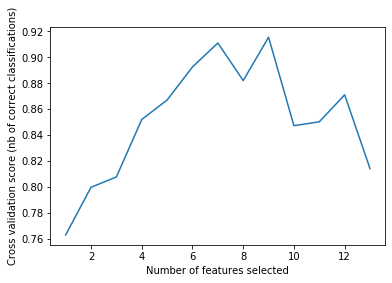

In [33]:
rfe = rfe_accuracy
print("Optimal number of features : %d" % rfe.n_features_)
print("Optimal number of features : %s" % str(rfe.support_))


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()


In [ ]:
mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
plt.figure()
vals_correct, bins, _ = plt.hist(comparisons['predicted'][mask & (comparisons['accuracy'] == 1)], alpha=0.5, label='good', bins=30)
vals_incorrect,_,_ = plt.hist(comparisons['predicted'][mask & (comparisons['accuracy'] == 0)], alpha=0.5, label='bad', bins=bins)
plt.xlabel('predicted probability that the user is good')
plt.ylabel('count')
plt.legend()

In [ ]:
def get_class_color(name):
    if users.loc[name]['class'] == 'undefined':
        return (0.5, 0.5, 0.5)
    elif users.loc[name]['class'] == 'bad':
        return (1, 0, 0)
    elif users.loc[name]['class'] == 'good':
        return (0, 1, 0)
    elif users.loc[name]['class'] == 'region':
        return (0, 0, 1)
    
    return (0.5, 0.5, 0.5)

# comparisons = comparisons.drop(columns=('color'))
comparisons = comparisons.join(comparisons.apply(lambda x: get_class_color(x.name), axis=1).rename('color'))

# #%%
# plt.figure()
# plt.ylabel('relative importance')
# plt.title('Feature Importances')
# plt.xticks(rotation=90)
# plt.bar(features, clf.feature_importances_)

In [ ]:
plt.figure(figsize=(5, 5))
# plt.xlim((20, 100))
# plt.ylim((20, 100))
# plt.axis('scaled')
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
# plt.scatter(comparisons['predicted'], comparisons['accuracy'], c=comparisons['color'].values)
plt.scatter(comparisons['predicted'], comparisons['accuracy'], c=comparisons['split_num'])
# plt.scatter(comparisons['predicted'], comparisons['confidence'], c=comparisons['color'].values)

# z = np.polyfit(comparisons['predicted'], comparisons['accuracy'], 1)
# p = np.poly1d(z)
# plt.plot(comparisons['predicted'], p(comparisons['predicted']), 
#     label=f"y={z[0]:2f}x+({z[1]:2f}), {r2_score(comparisons['accuracy'], p(comparisons['predicted'])):2f}")
plt.legend()



In [ ]:
.portable.portableplt.figure(figsize=(5, 5))
plt.xlim((20, 100))
plt.ylim((20, 100))
plt.axis('scaled')
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
    X_train, X_test = users.index[train_index], users.index[test_index]
    y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]

    #%%
    from sklearn.ensemble import BaggingRegressor
    clf = BaggingRegressor(n_jobs=-1, random_state=0, n_estimators=100)

    #%%
    np.array([list(l) for l in comparisons.loc[X_train]['prob_hist'].values])

    #%%
    clf.fit([list(l) for l in comparisons.loc[X_train]['prob_hist'].values], comparisons.loc[X_train]['accuracy'])


    #%%
    prediction = clf.predict([list(l) for l in comparisons.loc[X_test]['prob_hist'].values])
    prediction = pd.Series(data=prediction, index=X_test)
    #%%
    plt.scatter(prediction, y_test)
    #%%



# Analysis of min labels vs. precision

In [18]:
%%time
warnings.filterwarnings('ignore')
def run_range(min_labels):
    try:
        print(min_labels)
        users_for_analysis = users.index[users['labels_validated'] > min_labels]
        users2 = users.loc[users_for_analysis]
        return get_p_r(users2, label_correctness)
    except Exception:
        return (-1, -1)
    
with mp.Pool(4) as p:
    results = p.map(run_range, np.arange(1,75))

11
6
16
1
17
2
12
7
18
3
8
13
19
9
4
14
20
10
15
5
21
26
31
36
22
32
27
37
23
33
28
38
24
39
34
29
40
25
30
35
41
46
51
56
42
57
52
47
43
58
53
48
44
59
49
54
45
60
55
50
61
66
71
62
67
72
63
68
64
73
69
65
74
70
CPU times: user 540 ms, sys: 186 ms, total: 726 ms
Wall time: 15min 17s


In [19]:
results = np.array(results)

In [20]:
results_with_min = np.concatenate((np.arange(2, 76).reshape(-1, 1), results), axis=1)
results_invalid = results_with_min[~(results == -1).any(axis=1)]
results_df = pd.DataFrame(data=results_invalid, columns=('min', 'precision', 'recall')).set_index('min')

In [21]:
results_df = results_df.iloc[results_df.index < 45]

Text(0, 0.5, 'recall')

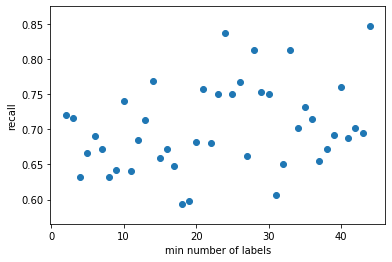

In [22]:
plt.figure()
# plt.scatter(results_df.index, results_df['precision'])
plt.scatter(results_df.index, results_df['recall'])
# plt.scatter(results_df.index, 2/(1/results_df['precision'] + 1/results_df['recall']))
plt.xlabel('min number of labels')
plt.ylabel('recall')

In [23]:
results[44]

array([0.87804878, 0.8372093 ])

In [ ]:
get_p_r

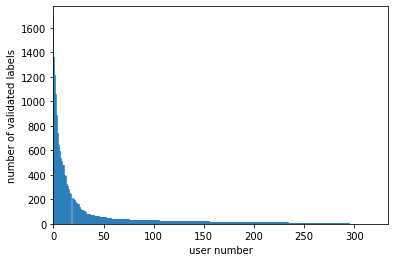

In [24]:
fig = plt.figure()
plt.vlines(np.arange(len(users['labels_validated'])), 0, np.sort(users['labels_validated'])[::-1], color='C0')
plt.axis((0, None, 0, None))
plt.xlabel('user number')
plt.ylabel('number of validated labels')
fig.savefig('a.svg')

In [25]:
.portable np.sort(users['labels_validated'])[::-1]

array([1690, 1365, 1217, 1063,  886,  737,  639,  592,  541,  510,  482,
        482,  399,  391,  321,  311,  284,  255,  242,  213,  203,  193,
        176,  172,  165,  164,  136,  117,  111,  110,  108,  101,   94,
         83,   79,   79,   76,   71,   70,   69,   68,   67,   67,   64,
         63,   62,   59,   57,   54,   54,   53,   53,   53,   47,   46,
         45,   44,   44,   43,   42,   42,   41,   41,   40,   40,   40,
         39,   39,   39,   39,   39,   38,   38,   38,   37,   36,   35,
         35,   34,   34,   33,   33,   32,   32,   32,   32,   32,   31,
         31,   31,   31,   30,   30,   30,   30,   30,   30,   29,   29,
         29,   28,   28,   28,   27,   27,   27,   26,   26,   26,   26,
         26,   26,   25,   25,   25,   25,   24,   24,   24,   23,   23,
         23,   23,   23,   23,   23,   22,   22,   22,   21,   21,   21,
         21,   21,   21,   21,   21,   21,   21,   20,   20,   20,   20,
         20,   20,   20,   20,   20,   20,   20,   

# DC Classification

In [71]:
dc_features = pd.read_csv('all_users_dc.csv')
dc_users = pd.read_csv('all_users_outputs_dc.csv')

In [73]:
dc_features.drop(columns='test', inplace=True)

In [74]:
dc_users['f1'] = 2 / (1/dc_users['precision'] + 1/dc_users['recall'])

In [159]:
dc_users['good'] = (dc_users['recall'] > 0.65)

In [160]:
np.mean(dc_users['recall'])

0.7071741296045524

In [165]:
from sklearn.dummy import DummyClassifier

In [170]:
comparisons = pd.DataFrame()
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(dc_users.index):
    X_train, X_test = dc_features.loc[train_index], dc_features.loc[test_index]
    y_train, y_test = dc_users['good'].loc[train_index], dc_users['good'].loc[test_index]
    
    rfe = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
           scoring='accuracy')
    
    rfe.fit(X_train, y_train)
#     clf = RandomForestClassifier(random_state=0, n_estimators=10)
    clf = DummyClassifier()
    clf.fit(X_train.values[:, rfe.support_], y_train)

    comparisons = comparisons.append(pd.DataFrame(
        data=np.stack((clf.predict(X_test.values[:, rfe.support_]).reshape(-1), y_test.values.reshape(-1)), axis=1), 
        columns=('predicted', 'actual'))
    )

comparisons.reset_index(inplace=True, drop=True)

In [171]:
mask = ~pd.isna(comparisons[['actual', 'predicted']]).any(axis=1)
print(precision_score(comparisons['actual'][mask], comparisons['predicted'][mask]))
print(recall_score(comparisons['actual'][mask], comparisons['predicted'][mask]))
print(accuracy_score(comparisons['actual'][mask], comparisons['predicted'][mask]))
print(confusion_matrix(comparisons['actual'][mask], comparisons['predicted'][mask]))

0.6585365853658537
0.627906976744186
0.5454545454545454
[[18 28]
 [32 54]]


Optimal number of features : 7
Optimal number of features : [ True  True  True  True  True  True  True]


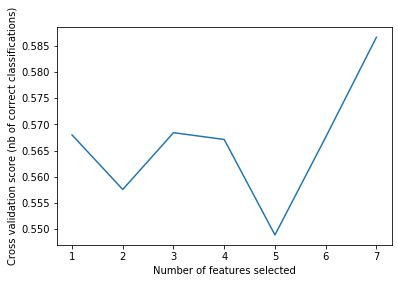

In [136]:
print("Optimal number of features : %d" % rfe.n_features_)
print("Optimal number of features : %s" % str(rfe.support_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()
